# check how to create desired format

In [1]:
import os, sys, random, time
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

d:\workspace\SakuraGit\python\torch\stocknet\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ohlc_column = ('Open','High','Low','Close')
file_path = os.path.abspath('./yfinance_5min_ex.csv')

In [3]:
data = pd.read_csv(file_path ,header=[0,1], index_col=0, parse_dates=True)
data.iloc[:10]

1605.T                                              \
                             Open    High     Low   Close Adj Close    Volume   
Datetime                                                                        
2022-10-17 09:00:00+09:00  1471.0  1472.0  1463.0  1468.0    1468.0       0.0   
2022-10-17 09:05:00+09:00  1468.0  1470.0  1459.0  1462.0    1462.0  534400.0   
2022-10-17 09:10:00+09:00  1463.0  1463.0  1457.0  1459.0    1459.0  451300.0   
2022-10-17 09:15:00+09:00  1458.0  1459.0  1455.0  1457.0    1457.0  360400.0   
2022-10-17 09:20:00+09:00  1457.0  1461.0  1456.0  1461.0    1461.0  303900.0   
2022-10-17 09:25:00+09:00  1460.0  1461.0  1458.0  1460.0    1460.0  165500.0   
2022-10-17 09:30:00+09:00  1460.0  1464.0  1460.0  1463.0    1463.0  173200.0   
2022-10-17 09:35:00+09:00  1463.0  1466.0  1461.0  1465.0    1465.0  357400.0   
2022-10-17 09:40:00+09:00  1465.0  1466.0  1462.0  1464.0    1464.0  246700.0   
2022-10-17 09:45:00+09:00  1464.0  1464.0  1462.0  1462.0    1462.0   48100.0   

                           1333.T                                            \
                             Open    High     Low   Close Adj Close  Volume   
Datetime                                                                      
2022-10-17 09:00:00+09:00  2420.0  2432.0  2419.0  2426.0    2426.0     0.0   
2022-10-17 09:05:00+09:00  2425.0  2427.0  2422.0  2423.0    2423.0  4400.0   
2022-10-17 09:10:00+09:00  2425.0  2425.0  2424.0  2424.0    2424.0  1800.0   
2022-10-17 09:15:00+09:00  2423.0  2424.0  2420.0  2420.0    2420.0  2400.0   
2022-10-17 09:20:00+09:00  2422.0  2422.0  2414.0  2416.0    2416.0  7100.0   
2022-10-17 09:25:00+09:00  2415.0  2415.0  2413.0  2413.0    2413.0   500.0   
2022-10-17 09:30:00+09:00  2413.0  2413.0  2411.0  2411.0    2411.0  1200.0   
2022-10-17 09:35:00+09:00  2412.0  2416.0  2409.0  2409.0    2409.0  2100.0   
2022-10-17 09:40:00+09:00     NaN     NaN     NaN     NaN       NaN     NaN   
2022-10-17 09:45:00+09:00  2411.0  2414.0  2409.0  2410.0    2410.0  3700.0   

                          1332.T                                          
                            Open   High    Low  Close Adj Close   Volume  
Datetime                                                                  
2022-10-17 09:00:00+09:00  543.0  544.0  543.0  544.0     544.0      0.0  
2022-10-17 09:05:00+09:00  544.0  544.0  543.0  543.0     543.0  24400.0  
2022-10-17 09:10:00+09:00  543.0  544.0  542.0  542.0     542.0   9500.0  
2022-10-17 09:15:00+09:00  543.0  543.0  541.0  542.0     542.0  11100.0  
2022-10-17 09:20:00+09:00  543.0  543.0  543.0  543.0     543.0  10900.0  
2022-10-17 09:25:00+09:00  543.0  543.0  542.0  542.0     542.0  15400.0  
2022-10-17 09:30:00+09:00  542.0  542.0  541.0  542.0     542.0   3000.0  
2022-10-17 09:35:00+09:00  542.0  542.0  541.0  541.0     541.0  22300.0  
2022-10-17 09:40:00+09:00  542.0  542.0  542.0  542.0     542.0   9400.0  
2022-10-17 09:45:00+09:00  542.0  542.0  541.0  541.0     541.0  16500.0

## Create Dataset from DataFrame

Check if output tonsor has expected format by concat data in following ways
- List
- pandas.unstack
- pandas.concat

Expected format

- form 1: ([ChunkSize, Num of Symbol, Num of Columns * DataLength])
- form 2: ([ChunkSize, Num of Symbol, Num of Columns, DataLength])
- form 3: ([ChunkSize, Num of Symbol * Num of Columns * DataLength])

### Using List

In [6]:
class ListDataset():
    
    def __init__(self, df, data_length, columns, symbols, form=1) -> None:
        self.data = df    
        self.indicies = random.choices(range(data_length, len(df)), k=len(df))
        self.symbols = symbols
        self.columns = columns
        self.data_length = data_length
        if form == 1:
            self.__input_func = self.get_item_func_3dims
        elif form == 2:
            self.__input_func = self.get_item_func_4dims
        elif form == 3:
            self.__input_func = self.get_item_func_2dims
        else:
            raise ValueError("from should be 1 to 3.")
        
    def get_item_func_2dims(self, ndx):
        batch_inputs = []
        if type(ndx) is int:
            ndx = slice(ndx, ndx+1)
        for index in self.indicies[ndx]:
            inputs = []
            for symbol in self.symbols:
                for column in self.columns:
                    inputs += data[symbol][column][index-self.data_length+1:index+1].values.tolist()
            batch_inputs.append(inputs)
        input = torch.tensor(inputs)
        return input, input
    
    def get_item_func_3dims(self, ndx):
        batch_inputs = []
        if type(ndx) is int:
            ndx = slice(ndx, ndx+1)
        for index in self.indicies[ndx]:
            inputs = []
            for symbol in self.symbols:
                temp = []
                for column in self.columns:
                    temp += data[symbol][column][index-self.data_length+1:index+1].values.tolist()
                inputs.append(temp)
            batch_inputs.append(inputs)
        input = torch.tensor(inputs)
        return input, input

    def get_item_func_4dims(self, ndx):
        batch_inputs = []
        if type(ndx) is int:
            ndx = slice(ndx, ndx+1)
        for index in self.indicies[ndx]:
            inputs = []
            for symbol in self.symbols:
                temp = []
                for column in self.columns:
                    temp.append(data[symbol][column][index-self.data_length+1:index+1].values.tolist())
                inputs.append(temp)
            batch_inputs.append(inputs)
        input = torch.tensor(inputs)
        return input, input

    def __getitem__(self, ndx):
        return self.__input_func(ndx)
    
    def __len__(self):
        return len(self.indicies)

In [7]:
target_columns = ["Open", "High", "Close"]
target_symbols = ["1605.T", "1333.T"]
data_size = 10

batch_size = slice(0,10)
ds = ListDataset(data, data_size, target_columns, target_symbols)
dl = DataLoader(ds, 10, drop_last=True, shuffle=False)

In [8]:
for input, ans in dl:
    print(input.shape)
    break
print(input[0])

torch.Size([10, 2, 30])
tensor([[1464., 1463., 1462., 1464., 1462., 1461., 1461., 1460., 1464., 1462.,
         1464., 1464., 1463., 1464., 1464., 1462., 1461., 1464., 1466., 1463.,
         1462., 1462., 1463., 1463., 1462., 1461., 1460., 1464., 1462., 1462.],
        [2411., 2410., 2408., 2411., 2411., 2412., 2414., 2412., 2414., 2416.,
         2414., 2410., 2410., 2411., 2413., 2415., 2414., 2413., 2415., 2417.,
         2410., 2409., 2410., 2410., 2411., 2414., 2413., 2413., 2415., 2417.]])


In [9]:
target_columns = ["Open", "High", "Close"]
target_symbols = ["1605.T", "1333.T"]
data_size = 10

batch_size = slice(0,10)
ds = ListDataset(data, data_size, target_columns, target_symbols, form=2)
dl = DataLoader(ds, 10, drop_last=True, shuffle=False)

In [10]:
for input, ans in dl:
    print(input.shape)
    break
print(input[0])

torch.Size([10, 2, 3, 10])
tensor([[[1461., 1461., 1465., 1467., 1466., 1466., 1465., 1465., 1467., 1466.],
         [1461., 1461., 1467., 1467., 1466., 1466., 1466., 1467., 1467., 1467.],
         [1461., 1461., 1467., 1466., 1466., 1465., 1465., 1466., 1466., 1466.]],

        [[2408., 2407., 2406., 2407., 2403., 2402., 2401., 2402., 2401., 2401.],
         [2408., 2407., 2409., 2407., 2403., 2402., 2401., 2402., 2401., 2402.],
         [2407., 2407., 2409., 2404., 2403., 2402., 2401., 2399., 2400., 2400.]]])


In [11]:
target_columns = ["Open", "High", "Close"]
target_symbols = ["1605.T", "1333.T"]
data_size = 10

batch_size = slice(0,10)
ds = ListDataset(data, data_size, target_columns, target_symbols, form=3)
dl = DataLoader(ds, 10, drop_last=True, shuffle=False)

In [12]:
for input, ans in dl:
    print(input.shape)
    break
print(input[0])

torch.Size([10, 60])
tensor([1461., 1460., 1463., 1462., 1462., 1460., 1460., 1461., 1461., 1465.,
        1463., 1463., 1463., 1462., 1463., 1461., 1462., 1461., 1461., 1467.,
        1461., 1462., 1462., 1461., 1460., 1460., 1461., 1461., 1461., 1467.,
          nan, 2410., 2410., 2411., 2409., 2408.,   nan, 2408., 2407., 2406.,
          nan, 2411., 2410., 2411., 2409., 2410.,   nan, 2408., 2407., 2409.,
          nan, 2409., 2410., 2410., 2409., 2410.,   nan, 2407., 2407., 2409.])


### Unstack

In [13]:
index = 10
columns = ["Open", "Close","High", "Low"]
data_size = 10
target_symbols = ["1605.T", "1333.T"]

In [14]:
class STACKDataset():
    
    def __init__(self, df, data_length, columns, symbols, form=1) -> None:
        self.data = df    
        self.indicies = random.choices(range(data_length, len(df)), k=len(df))
        self.symbols = symbols
        self.columns = columns
        self.data_length = data_length
        self.target_columns = [(symbol, column) for symbol in self.symbols for column in self.columns]
        if form == 1:
            self.__input_func = self.get_item_func_3dims
        elif form == 2:
            self.__input_func = self.get_item_func_4dims
        elif form == 3:
            self.__input_func = self.get_item_func_2dims
        else:
            raise ValueError("from should be 1 to 3.")

    def __common_input_func(self, ndx):
        if type(ndx) is int:
            ndx = slice(ndx, ndx+1)
        chunk_size = 0
        result = pd.Series(dtype=np.float64)
        for index in self.indicies[ndx]:
            temp = data[self.target_columns].iloc[index - self.data_length +1:index+1].unstack()
            result = pd.concat([result, temp])
            chunk_size+=1
        result = result.reset_index(drop=True)
        return torch.tensor(result), chunk_size

    def get_item_func_3dims(self, ndx):
        torch_input, chunk_size = self.__common_input_func(ndx)
        input = torch_input.reshape((chunk_size*len(self.symbols), len(self.columns) * self.data_length))
        return input, input
    
    def get_item_func_4dims(self, ndx):
        torch_input, chunk_size = self.__common_input_func(ndx)
        input = torch_input.reshape((chunk_size*len(self.symbols), len(self.columns), self.data_length))
        return input, input

    def get_item_func_2dims(self, ndx):
        torch_input, chunk_size = self.__common_input_func(ndx)
        return torch_input, torch_input

    def __getitem__(self, ndx):
        return self.__input_func(ndx)
    
    def __len__(self):
        return len(self.indicies)

In [15]:
target_columns = ["Open", "High", "Close"]
target_symbols = ["1605.T", "1333.T"]
data_size = 10

batch_size = 10
ds = STACKDataset(data, data_size, target_columns, target_symbols)
dl = DataLoader(ds, batch_size=batch_size, drop_last=True, shuffle=False)

In [16]:
for input, ans in dl:
    print(input.shape)
    break
print(input[0])

torch.Size([10, 2, 30])
tensor([[1463., 1462., 1462., 1460., 1460., 1461., 1461., 1465., 1467., 1466.,
         1463., 1462., 1463., 1461., 1462., 1461., 1461., 1467., 1467., 1466.,
         1462., 1461., 1460., 1460., 1461., 1461., 1461., 1467., 1466., 1466.],
        [2410., 2411., 2409., 2408.,   nan, 2408., 2407., 2406., 2407., 2403.,
         2410., 2411., 2409., 2410.,   nan, 2408., 2407., 2409., 2407., 2403.,
         2410., 2410., 2409., 2410.,   nan, 2407., 2407., 2409., 2404., 2403.]],
       dtype=torch.float64)


In [17]:
ds = STACKDataset(data, data_size, target_columns, target_symbols, form=2)
dl = DataLoader(ds, batch_size=batch_size, drop_last=True, shuffle=False)

In [18]:
for input, ans in dl:
    print(input.shape)
    break
print(input[0])

torch.Size([10, 2, 3, 10])
tensor([[[1464., 1462., 1461., 1461., 1460., 1464., 1462., 1463., 1463., 1463.],
         [1464., 1464., 1462., 1461., 1464., 1466., 1463., 1464., 1464., 1464.],
         [1463., 1462., 1461., 1460., 1464., 1462., 1462., 1463., 1462., 1460.]],

        [[2411., 2411., 2412., 2414., 2412., 2414., 2416., 2416., 2413., 2412.],
         [2411., 2413., 2415., 2414., 2413., 2415., 2417., 2416., 2413., 2412.],
         [2410., 2411., 2414., 2413., 2413., 2415., 2417., 2416., 2413., 2411.]]],
       dtype=torch.float64)


In [19]:
ds = STACKDataset(data, data_size, target_columns, target_symbols, form=3)
dl = DataLoader(ds, batch_size=batch_size, drop_last=True, shuffle=False)

In [20]:
for input, ans in dl:
    print(input.shape)
    break
print(input[0])

torch.Size([10, 60])
tensor([1460., 1463., 1465., 1464., 1463., 1462., 1464., 1462., 1461., 1461.,
        1464., 1466., 1466., 1464., 1464., 1463., 1464., 1464., 1462., 1461.,
        1463., 1465., 1464., 1462., 1462., 1463., 1463., 1462., 1461., 1460.,
        2413., 2412.,   nan, 2411., 2410., 2408., 2411., 2411., 2412., 2414.,
        2413., 2416.,   nan, 2414., 2410., 2410., 2411., 2413., 2415., 2414.,
        2411., 2409.,   nan, 2410., 2409., 2410., 2410., 2411., 2414., 2413.],
       dtype=torch.float64)


### Using pandas concat

In [21]:
class PDDataset():
    
    def __init__(self, df, data_length, columns, symbols, form=1) -> None:
        self.data = df    
        self.indicies = random.choices(range(data_length, len(df)), k=len(df))
        self.symbols = symbols
        self.columns = columns
        self.data_length = data_length
        self.target_columns = [(symbol, column) for symbol in self.symbols for column in self.columns]
        if form == 1:
            self.__input_func = self.get_item_func_3dims
        elif form == 2:
            self.__input_func = self.get_item_func_4dims
        elif form == 3:
            self.__input_func = self.get_item_func_2dims
        else:
            raise ValueError("from should be 1 to 3.")
    
        
    def __common_input_func(self, ndx):
        if type(ndx) is int:
            ndx = slice(ndx, ndx+1)
        chunk_size = 0
        result = []
        for index in self.indicies[ndx]:
            result.append(pd.concat([data[symbol][self.columns].iloc[index-self.data_length+1:index+1].T for symbol in self.symbols]).values)
            chunk_size+=1
        return torch.tensor(result), chunk_size

    def get_item_func_3dims(self, ndx):
        torch_input, chunk_size = self.__common_input_func(ndx)
        input = torch_input.reshape((chunk_size*len(self.symbols), len(self.columns) * self.data_length))
        return input, input
    
    def get_item_func_2dims(self, ndx):
        torch_input, chunk_size = self.__common_input_func(ndx)
        input = torch_input.reshape((chunk_size * len(self.symbols)* len(self.columns) * self.data_length))
        return input, input
        
    def get_item_func_4dims(self, ndx):
        torch_input, chunk_size = self.__common_input_func(ndx)
        input = torch_input.reshape((chunk_size*len(self.symbols), len(self.columns), self.data_length))
        return input, input

    def __getitem__(self, ndx):
        return self.__input_func(ndx)
    
    def __len__(self):
        return len(self.indicies)

In [22]:
target_columns = ["Open", "High", "Close"]
target_symbols = ["1605.T", "1333.T"]
data_size = 10

batch_size = 10
ds = PDDataset(data, data_size, target_columns, target_symbols)
dl = DataLoader(ds, batch_size=batch_size, drop_last=True, shuffle=False)

In [23]:
for input, ans in dl:
    print(input.shape)
    break
print(input[0])

torch.Size([10, 2, 30])
tensor([[1462., 1462., 1460., 1460., 1461., 1461., 1465., 1467., 1466., 1466.,
         1462., 1463., 1461., 1462., 1461., 1461., 1467., 1467., 1466., 1466.,
         1461., 1460., 1460., 1461., 1461., 1461., 1467., 1466., 1466., 1465.],
        [2411., 2409., 2408.,   nan, 2408., 2407., 2406., 2407., 2403., 2402.,
         2411., 2409., 2410.,   nan, 2408., 2407., 2409., 2407., 2403., 2402.,
         2410., 2409., 2410.,   nan, 2407., 2407., 2409., 2404., 2403., 2402.]],
       dtype=torch.float64)


C:\Users\sato\AppData\Local\Temp\ipykernel_9132\2895283676.py:28: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:210.)
  return torch.tensor(result), chunk_size


In [24]:
ds = PDDataset(data, data_size, target_columns, target_symbols, form=2)
dl = DataLoader(ds, batch_size=batch_size, drop_last=True, shuffle=False)
for input, ans in dl:
    print(input.shape)
    break
print(input[0])

torch.Size([10, 2, 3, 10])
tensor([[[1464., 1463., 1462., 1464., 1462., 1461., 1461., 1460., 1464., 1462.],
         [1464., 1464., 1463., 1464., 1464., 1462., 1461., 1464., 1466., 1463.],
         [1462., 1462., 1463., 1463., 1462., 1461., 1460., 1464., 1462., 1462.]],

        [[2411., 2410., 2408., 2411., 2411., 2412., 2414., 2412., 2414., 2416.],
         [2414., 2410., 2410., 2411., 2413., 2415., 2414., 2413., 2415., 2417.],
         [2410., 2409., 2410., 2410., 2411., 2414., 2413., 2413., 2415., 2417.]]],
       dtype=torch.float64)


In [25]:
ds = PDDataset(data, data_size, target_columns, target_symbols, form=3)
dl = DataLoader(ds, batch_size=batch_size, drop_last=True, shuffle=False)
for input, ans in dl:
    print(input.shape)
    break
print(input[0])

torch.Size([10, 60])
tensor([1460., 1461., 1460., 1463., 1462., 1462., 1460., 1460., 1461., 1461.,
        1461., 1463., 1463., 1463., 1462., 1463., 1461., 1462., 1461., 1461.,
        1461., 1461., 1462., 1462., 1461., 1460., 1460., 1461., 1461., 1461.,
        2411.,   nan, 2410., 2410., 2411., 2409., 2408.,   nan, 2408., 2407.,
        2411.,   nan, 2411., 2410., 2411., 2409., 2410.,   nan, 2408., 2407.,
        2409.,   nan, 2409., 2410., 2410., 2409., 2410.,   nan, 2407., 2407.],
       dtype=torch.float64)


## Compare cosume time

### Change Form with fixed size

In [26]:
available_forms = [1, 2, 3]
total_count = 1000
data_size = 10
batch_size = 5

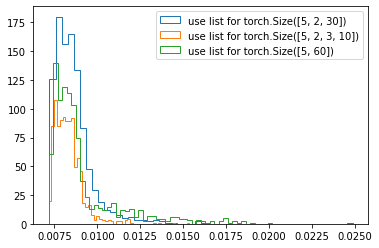

In [27]:
target_columns = ["Open", "High", "Close"]
target_symbols = ["1605.T", "1333.T"]

time_results = {}
shapes = {}
for form in available_forms:
    consumed_times = []
    ds = ListDataset(data, data_size, target_columns, target_symbols, form=form)
    dl = DataLoader(ds, batch_size=batch_size, drop_last=True, shuffle=False)
    for index in range(0, total_count):
        start_time = time.perf_counter()
        for input, ans in dl:
            break
        end_time = time.perf_counter()
        consumed_times.append(end_time - start_time)
    time_results[form] = np.array(consumed_times)
    shapes[form] = input.shape

for form in available_forms:
    plt.hist(time_results[form], bins=50, histtype="step", label=f"use list for {shapes[form]}")
plt.legend()
plt.show()

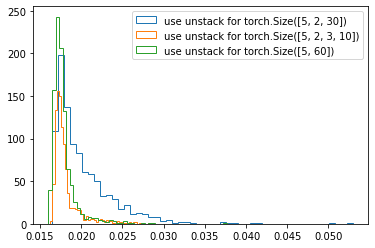

In [28]:
target_columns = ["Open", "High", "Close"]
target_symbols = ["1605.T", "1333.T"]

time_results = {}
shapes = {}
for form in available_forms:
    consumed_times = []
    ds = STACKDataset(data, data_size, target_columns, target_symbols, form=form)
    dl = DataLoader(ds, batch_size=batch_size, drop_last=True, shuffle=False)
    for index in range(0, total_count):
        start_time = time.perf_counter()
        for input, ans in dl:
            break
        end_time = time.perf_counter()
        consumed_times.append(end_time - start_time)
    time_results[form] = np.array(consumed_times)
    shapes[form] = input.shape

for form in available_forms:
    plt.hist(time_results[form], bins=50, histtype="step", label=f"use unstack for {shapes[form]}")
plt.legend()
plt.show()

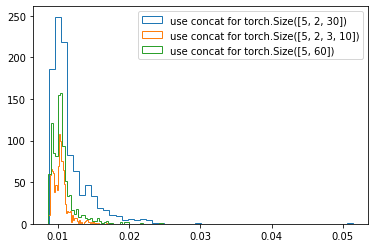

In [29]:
target_columns = ["Open", "High", "Close"]
target_symbols = ["1605.T", "1333.T"]

time_results = {}
shapes = {}
for form in available_forms:
    consumed_times = []
    ds = PDDataset(data, data_size, target_columns, target_symbols, form=form)
    dl = DataLoader(ds, batch_size=batch_size, drop_last=True, shuffle=False)
    for index in range(0, total_count):
        start_time = time.perf_counter()
        for input, ans in dl:
            break
        end_time = time.perf_counter()
        consumed_times.append(end_time - start_time)
    time_results[form] = np.array(consumed_times)
    shapes[form] = input.shape

for form in available_forms:
    plt.hist(time_results[form], bins=50, histtype="step", label=f"use concat for {shapes[form]}")
plt.legend()
plt.show()

### Change Size with fixed form

In [30]:
entired_columns = ["Open", "High", "Low", "Close", "Adj Close", "Volume"]
entire_symbols = ["1605.T", "1333.T", "	1332.T"]

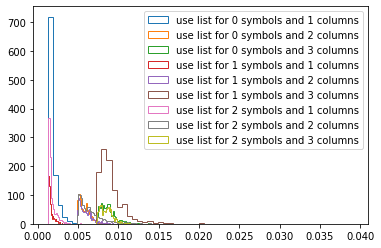

In [31]:
time_results = {}
shapes = {}

for symbol_length in range(0, len(entire_symbols)):
    time_results[symbol_length] = {}
    shapes[symbol_length] = {}
    
    for column_length in available_forms:
        consumed_times = []
        ds = ListDataset(data, data_size, entired_columns[:column_length], target_symbols[:column_length])
        dl = DataLoader(ds, batch_size=batch_size, drop_last=True, shuffle=False)
        for index in range(0, total_count):
            start_time = time.perf_counter()
            for input, ans in dl:
                break
            end_time = time.perf_counter()
            consumed_times.append(end_time - start_time)
        time_results[symbol_length][column_length] = np.array(consumed_times)
        shapes[symbol_length][column_length] = input.shape

for symbol_length in range(0, len(entire_symbols)):
    for column_length in available_forms:
        plt.hist(time_results[symbol_length][column_length], bins=50, histtype="step", label=f"use list for {symbol_length} symbols and {column_length} columns")
plt.legend()
plt.show()

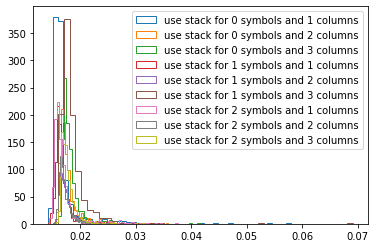

In [32]:
time_results = {}
shapes = {}

for symbol_length in range(0, len(entire_symbols)):
    time_results[symbol_length] = {}
    shapes[symbol_length] = {}
    
    for column_length in available_forms:
        consumed_times = []
        ds = STACKDataset(data, data_size, entired_columns[:column_length], target_symbols[:column_length])
        dl = DataLoader(ds, batch_size=batch_size, drop_last=True, shuffle=False)
        for index in range(0, total_count):
            start_time = time.perf_counter()
            for input, ans in dl:
                break
            end_time = time.perf_counter()
            consumed_times.append(end_time - start_time)
        time_results[symbol_length][column_length] = np.array(consumed_times)
        shapes[symbol_length][column_length] = input.shape

for symbol_length in range(0, len(entire_symbols)):
    for column_length in available_forms:
        plt.hist(time_results[symbol_length][column_length], bins=50, histtype="step", label=f"use stack for {symbol_length} symbols and {column_length} columns")
plt.legend()
plt.show()

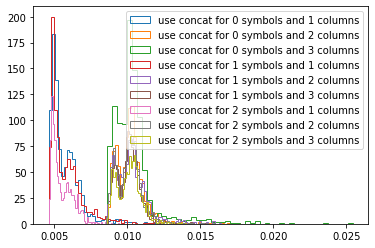

In [33]:
time_results = {}
shapes = {}

for symbol_length in range(0, len(entire_symbols)):
    time_results[symbol_length] = {}
    shapes[symbol_length] = {}
    
    for column_length in available_forms:
        consumed_times = []
        ds = PDDataset(data, data_size, entired_columns[:column_length], target_symbols[:column_length])
        dl = DataLoader(ds, batch_size=batch_size, drop_last=True, shuffle=False)
        for index in range(0, total_count):
            start_time = time.perf_counter()
            for input, ans in dl:
                break
            end_time = time.perf_counter()
            consumed_times.append(end_time - start_time)
        time_results[symbol_length][column_length] = np.array(consumed_times)
        shapes[symbol_length][column_length] = input.shape

for symbol_length in range(0, len(entire_symbols)):
    for column_length in available_forms:
        plt.hist(time_results[symbol_length][column_length], bins=50, histtype="step", label=f"use concat for {symbol_length} symbols and {column_length} columns")
plt.legend()
plt.show()

### Change Length only

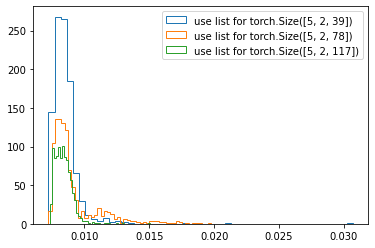

In [34]:
target_columns = ["Open", "High", "Close"]
target_symbols = ["1605.T", "1333.T"]
interval = int(len(data)/3)

time_results = {}
shapes = {}
for data_size in range(interval, len(data), interval):
    consumed_times = []
    ds = ListDataset(data, data_size, target_columns, target_symbols)
    dl = DataLoader(ds, batch_size=batch_size, drop_last=True, shuffle=False)
    for index in range(0, total_count):
        start_time = time.perf_counter()
        for input, ans in dl:
            break
        end_time = time.perf_counter()
        consumed_times.append(end_time - start_time)
    time_results[data_size] = np.array(consumed_times)
    shapes[data_size] = input.shape

for data_size in range(interval, len(data), interval):
    plt.hist(time_results[data_size], bins=50, histtype="step", label=f"use list for {shapes[data_size]}")
plt.legend()
plt.show()

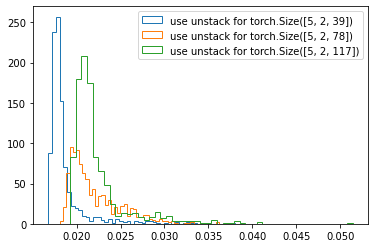

In [35]:
target_columns = ["Open", "High", "Close"]
target_symbols = ["1605.T", "1333.T"]
interval = int(len(data)/3)

time_results = {}
shapes = {}
for data_size in range(interval, len(data), interval):
    consumed_times = []
    ds = STACKDataset(data, data_size, target_columns, target_symbols)
    dl = DataLoader(ds, batch_size=batch_size, drop_last=True, shuffle=False)
    for index in range(0, total_count):
        start_time = time.perf_counter()
        for input, ans in dl:
            break
        end_time = time.perf_counter()
        consumed_times.append(end_time - start_time)
    time_results[data_size] = np.array(consumed_times)
    shapes[data_size] = input.shape

for data_size in range(interval, len(data), interval):
    plt.hist(time_results[data_size], bins=50, histtype="step", label=f"use unstack for {shapes[data_size]}")
plt.legend()
plt.show()

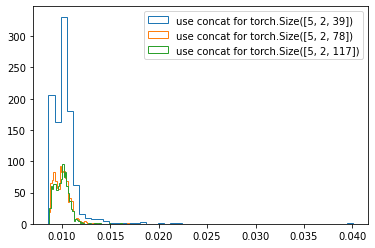

In [36]:
target_columns = ["Open", "High", "Close"]
target_symbols = ["1605.T", "1333.T"]
interval = int(len(data)/3)

time_results = {}
shapes = {}
for data_size in range(interval, len(data), interval):
    consumed_times = []
    ds = PDDataset(data, data_size, target_columns, target_symbols)
    dl = DataLoader(ds, batch_size=batch_size, drop_last=True, shuffle=False)
    for index in range(0, total_count):
        start_time = time.perf_counter()
        for input, ans in dl:
            break
        end_time = time.perf_counter()
        consumed_times.append(end_time - start_time)
    time_results[data_size] = np.array(consumed_times)
    shapes[data_size] = input.shape

for data_size in range(interval, len(data), interval):
    plt.hist(time_results[data_size], bins=50, histtype="step", label=f"use concat for {shapes[data_size]}")
plt.legend()
plt.show()